In [1]:
# Initial imports
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import datetime
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from matplotlib import pyplot as plt
plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Dark2')
import statsmodels.tsa.vector_ar.util as util
import os
directory = 'C:/Users/tmund/Documents/Submissions/HigherMomentsRep/'
os.chdir(directory)

In [2]:
# Get shocks
stdevshock = pd.read_pickle('Output/7 - Shocks/StDevShock.pkl')
skewshock = pd.read_pickle('Output/7 - Shocks/SkewShock.pkl')

In [3]:
# Get data series from FRED
start = datetime.datetime(1998, 5, 1)
end = datetime.datetime(2018, 8, 20)
freddata = web.DataReader(['LREM64TTGBQ156S', 'GBRPROINDQISMEI', 'IRSTCI01GBM156N', 'CLVMNACSCAB1GQUK'], 'fred', start, end)
freddata.rename(columns={"LREM64TTGBQ156S": "Emp", "GBRPROINDQISMEI": "IP", "IRSTCI01GBM156N": "r", 'CLVMNACSCAB1GQUK':'GDP'}, inplace=True)

In [4]:
# Get data series from excel
ftse = pd.read_csv('Data/FTSE/^FTSE.csv')
ftse.set_index('Date', inplace=True)
ftse.index = ftse.index.astype('datetime64[ns]')

In [5]:
# Put shock in as a quarterly variable
stdevshock.index = stdevshock.index.map(lambda dt: dt.replace(day=1))
stdevshock.index = stdevshock.index - pd.DateOffset(months=1)
skewshock.index = skewshock.index.map(lambda dt: dt.replace(day=1))
skewshock.index = skewshock.index - pd.DateOffset(months=1)

In [6]:
# Combine dataframes
X = pd.concat([freddata, ftse, stdevshock, skewshock], axis=1)

In [7]:
# Clean up 
X.drop(columns=['High', 'Low', 'Adj Close', 'Volume'], inplace=True)
X = X.iloc[::3, :]

In [8]:
# Data transforms
X.Emp = X.Emp.apply(lambda x: np.log(x))
X.IP = X.IP.apply(lambda x: np.log(x))
X.Open = X.Open.apply(lambda x: np.log(x))
X.Close = X.Close.apply(lambda x: np.log(x))
X.GDP = X.GDP.apply(lambda x: np.log(x))
X['StDevresid_resid'] = X['StDevresid'] - X['StDevresid_fitted_ir']
X['Skewresid_resid'] = X['Skewresid'] - X['Skewresid_fitted_qa']

In [9]:
X.head()

,Emp,IP,r,GDP,Open,Close,StDevresid,StDevresid_fitted_ir,Skewresid,Skewresid_fitted_qa,StDevresid_resid,Skewresid_resid
1995-04-01,NaN,NaN,NaN,NaN,8.050129,8.076111,NaN,NaN,NaN,NaN,NaN,NaN
1995-07-01,NaN,NaN,NaN,NaN,8.104764,8.149977,NaN,NaN,NaN,NaN,NaN,NaN
1995-10-01,NaN,NaN,NaN,NaN,8.163542,8.168798,NaN,NaN,NaN,NaN,NaN,NaN
1996-01-01,NaN,NaN,NaN,NaN,8.213192,8.231988,NaN,NaN,NaN,NaN,NaN,NaN
1996-04-01,NaN,NaN,NaN,NaN,8.213951,8.247456,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# Do model(s)
y_var_list = ['StDevresid', 'StDevresid_fitted_ir', 'Skewresid', 'Skewresid_fitted_qa', 'StDevresid_resid', 'Skewresid_resid']
y_var_dict = {'StDevresid':[],
             'StDevresid_fitted_ir':[],
             'Skewresid':[],
             'Skewresid_fitted_qa':[]}

for y in y_var_list:
    X_est = X.loc[:, [y, 'Open', 'r', 'Emp', 'GDP']]
    X_est= X_est.dropna()
    model = VAR(X_est)
    results = model.fit(4) # fit VAR with 4 lags
    irf = results.irf(12)
    y_var_dict[y] = irf

C:\Users\Tim\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Tim\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Tim\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Tim\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ig

In [11]:
# Model variations

model_list = ['bi', 'rbi', 'lags', 'noftse']
models = {'bi':[],
         'rbi':[],
         'lags':[],
         'noftse':[]}

X_est = X.loc[:, ['StDevresid_fitted_ir', 'GDP']]
X_est= X_est.dropna()
model = VAR(X_est)
results = model.fit(4) # fit VAR with 4 lags
irf = results.irf(12)
models['bi'] = irf

X_est = X.loc[:, ['GDP', 'StDevresid_fitted_ir']]
X_est= X_est.dropna()
model = VAR(X_est)
results = model.fit(4) # fit VAR with 4 lags
irf = results.irf(12)
models['rbi'] = irf

X_est = X.loc[:, ['StDevresid_fitted_ir', 'Open', 'r', 'Emp', 'GDP']]
X_est= X_est.dropna()
model = VAR(X_est)
results = model.fit(6) # fit VAR with 6 lags
irf = results.irf(12)
models['lags'] = irf

X_est = X.loc[:, ['StDevresid_fitted_ir', 'r', 'Emp', 'GDP']]
X_est= X_est.dropna()
model = VAR(X_est)
results = model.fit(4) # fit VAR with 6 lags
irf = results.irf(12)
models['noftse'] = irf

C:\Users\Tim\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Tim\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Tim\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Tim\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ig

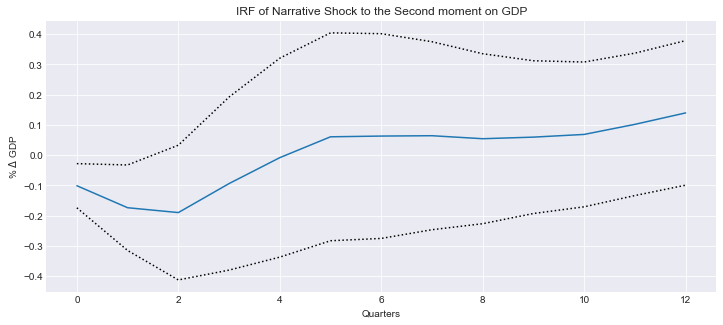

In [12]:
# Make second moment gdp plot
i=4
j=0
plt.figure(figsize=(12, 5))

plt.subplot(1, 1, 1)
stderr = y_var_dict['StDevresid_fitted_ir'].cov(orth=True)
sig = np.sqrt(stderr[:, j * 5 + i, j * 5 + i]) #  for shock j on variable i, for total k variables
q = util.norm_signif_level(0.1) # alpha signifcanle level
plt.plot((y_var_dict['StDevresid_fitted_ir'].orth_irfs[:, i, j])*100)
plt.plot((y_var_dict['StDevresid_fitted_ir'].orth_irfs[:, i, j] - q*sig)*100, 'k:')
plt.plot((y_var_dict['StDevresid_fitted_ir'].orth_irfs[:, i, j] + q*sig)*100, 'k:')
plt.ylabel('% $\Delta$ GDP')
plt.xlabel('Quarters')
plt.title('IRF of Narrative Shock to the Second moment on GDP')

# plt.subplot(1, 2, 2)
# stderr = y_var_dict['StDevresid_resid'].cov(orth=True)
# sig = np.sqrt(stderr[:, j * 5 + i, j * 5 + i]) #  for shock j on variable i, for total k variables
# q = util.norm_signif_level(0.1) # alpha signifcanle level
# plt.plot((y_var_dict['StDevresid_resid'].orth_irfs[:, i, j])*100)
# plt.plot((y_var_dict['StDevresid_resid'].orth_irfs[:, i, j] - q*sig)*100, 'k--')
# plt.plot((y_var_dict['StDevresid_resid'].orth_irfs[:, i, j] + q*sig)*100, 'k--')
# plt.ylabel('% $\Delta$ GDP')
# plt.xlabel('Quarters')
# plt.title('IRF of component orthongal to Narrative Shock on GDP')

#plt.savefig('C:/Users/Tim/Documents/Nuffield/MphilThesis/DataVis/VAR/Figs/VARirfs.pdf')
plt.show()


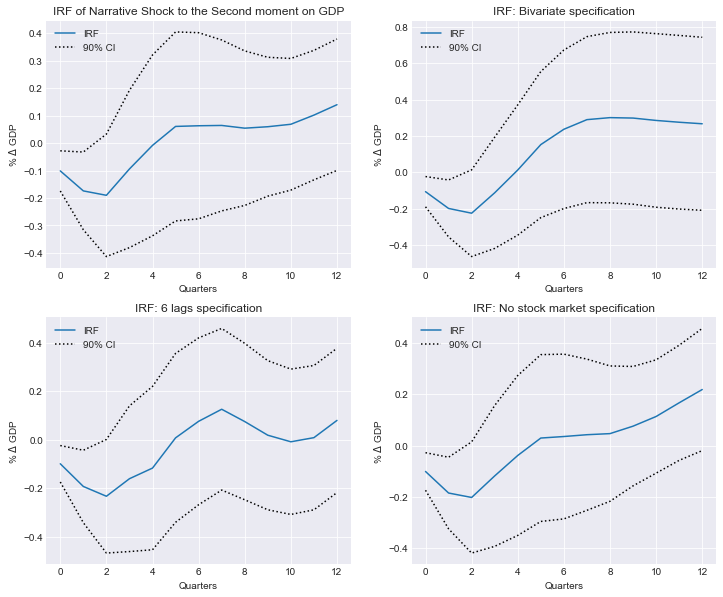

In [20]:
# Make model variation plot
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
i=4
j=0
stderr = y_var_dict['StDevresid_fitted_ir'].cov(orth=True)
sig = np.sqrt(stderr[:, j * 5 + i, j * 5 + i]) #  for shock j on variable i, for total k variables
q = util.norm_signif_level(0.1) # alpha signifcanle level
plt.plot((y_var_dict['StDevresid_fitted_ir'].orth_irfs[:, i, j])*100, label='IRF')
plt.plot((y_var_dict['StDevresid_fitted_ir'].orth_irfs[:, i, j] - q*sig)*100, 'k:', label='90% CI')
plt.plot((y_var_dict['StDevresid_fitted_ir'].orth_irfs[:, i, j] + q*sig)*100, 'k:')
plt.ylabel('% $\Delta$ GDP')
plt.xlabel('Quarters')
plt.title('IRF of Narrative Shock to the Second moment on GDP')
plt.legend()

plt.subplot(2, 2, 2)
stderr = models['bi'].cov(orth=True)
i=1
j=0
k=2
sig = np.sqrt(stderr[:, j * k + i, j * k + i]) #  for shock j on variable i, for total k variables
q = util.norm_signif_level(0.1) # alpha signifcanle level
plt.plot((models['bi'].orth_irfs[:, i, j])*100, label='IRF')
plt.plot((models['bi'].orth_irfs[:, i, j] - q*sig)*100, 'k:', label='90% CI')
plt.plot((models['bi'].orth_irfs[:, i, j] + q*sig)*100, 'k:')
plt.ylabel('% $\Delta$ GDP')
plt.xlabel('Quarters')
plt.title('IRF: Bivariate specification')
plt.legend()

plt.subplot(2, 2, 3)
stderr = models['lags'].cov(orth=True)
i=4
j=0
k=5
sig = np.sqrt(stderr[:, j * k + i, j * k + i]) #  for shock j on variable i, for total k variables
q = util.norm_signif_level(0.1) # alpha signifcanle level
plt.plot((models['lags'].orth_irfs[:, i, j])*100, label='IRF')
plt.plot((models['lags'].orth_irfs[:, i, j] - q*sig)*100, 'k:', label='90% CI')
plt.plot((models['lags'].orth_irfs[:, i, j] + q*sig)*100, 'k:')
plt.ylabel('% $\Delta$ GDP')
plt.xlabel('Quarters')
plt.title('IRF: 6 lags specification')
plt.legend()

plt.subplot(2, 2, 4)
stderr = models['noftse'].cov(orth=True)
i=3
j=0
k=4
sig = np.sqrt(stderr[:, j * k + i, j * k + i]) #  for shock j on variable i, for total k variables
q = util.norm_signif_level(0.1) # alpha signifcanle level
plt.plot((models['noftse'].orth_irfs[:, i, j])*100, label='IRF')
plt.plot((models['noftse'].orth_irfs[:, i, j] - q*sig)*100, 'k:', label='90% CI')
plt.plot((models['noftse'].orth_irfs[:, i, j] + q*sig)*100, 'k:')
plt.ylabel('% $\Delta$ GDP')
plt.xlabel('Quarters')
plt.title('IRF: No stock market specification')
plt.legend()

plt.savefig('DataVis/VAR/Figs/VARirfs.pdf')
plt.show()